# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for CLT to hold (read CLT carefully), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the CLT, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> Start by computing the margin of error and confidence interval.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What test did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


1) Is the distribution of body temperatures normal? 

To answer this question, we calculate the mean and standard deviation from the data, generate random samples from the normal distribution with computed  mean and standard deviation, and compare the plots of ecdf's (empirical cumulative distributions) obtained respectively from the given data and sampled data. It follows from the plot below that the body temperatures can be regarded normally distributed.

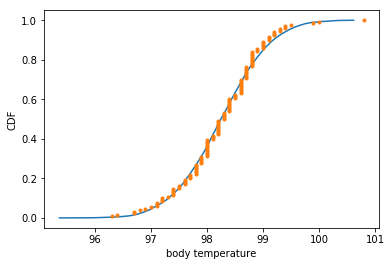

In [2]:
import numpy as np

import matplotlib.pyplot as plt

# Empirical cumulative distribution function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    n = len(data) # Number of data points: n
    x = np.sort(data) # x-data for the ECDF: x
    y = np.arange(1, n+1) / n  # y-data for the ECDF: y

    return x, y

mean = np.mean(df.temperature)
std = np.std(df.temperature)
samples = np.random.normal(mean, std, size=10000)

x, y = ecdf(df.temperature)  # ecdf from the given data

x_theor, y_theor = ecdf(samples)  #ecdf from sampled data

# Plotting ecdf's
_ = plt.plot(x_theor, y_theor)
_ = plt.plot(x, y, marker='.', linestyle='none')

_= plt.xlabel('body temperature')
_ = plt.ylabel('CDF')
plt.show()


A much more quantitatively sound test can be found in scipy.stats module. This is the test whether our sample differs from a normal distribution. The null hypothesis is that a sample comes from a normal distribution. The test returns a p-value, which for df.temperature is equal to 0.258. Such a large number of p-value is in a very strong favor of the null hypothesis, and hence the fact that the body temperatures are normally distributed.

In [13]:
from scipy import stats

k2, p = stats.normaltest(df.temperature)
print("p-value is:", p)

p-value is: 0.258747986349


2)  Is the sample size large? Are the observations independent? 

The size of the sample is equal to 130, and it seems to be not very large. However, it is large enough to assume that observations obey normal distribution. To check whether the observations are independent, we generate a random sample of the same size as df.temperature using normal distribution with np.mean(df.temperature) and np.std(df.temperature). Then we will test the hypothesis that the mean of the generated sample is the same as np.mean(df.temperature), using bootstrap replicates. 

In [14]:
# Auxilliary function: Generating the bootstrap replicates

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    
    bs_replicates = np.empty(size)

    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates


In [15]:
mean = np.mean(df.temperature)
std = np.std(df.temperature)
samples = np.random.normal(mean, std, size=len(df.temperature))


# shift our sampled data, so that the mean of the sampled data is equal to np.mean(df.temperature)
samples_shifted = samples - np.mean(samples) + mean

def diff_from_mean(data):
    return np.mean(data) - mean

diff_observed = diff_from_mean(samples)
# print(diff_observed)

bs_replicates = draw_bs_reps(samples_shifted, diff_from_mean, 10000)
p_value = np.sum(abs(bs_replicates) >= abs(diff_observed)) / 10000
print("p-value is:", p_value)

p-value is: 0.256


Again, the large p-value suggests that our data in df.temperature independently come from normal distribution.

3) Is the true population mean really 98.6 degrees F? 

To answer this question, we test the hypothesis that np.mean(df.temperature) is equal to 98.6 F using a one-sample test. We will use the one-sample test, beacuse we do not have the data that led us to believe that mean temperature can be 98.6 F.  We will proceed almost identically to the previous question and generate the shifted sample data with the new mean equal to 98.6 

In [16]:
def diff_from_98_6(data):
    return np.mean(data) - 98.6

df_temperature_shifted = df.temperature - mean + 98.6

diff_obs = diff_from_98_6(df.temperature)
#print(diff_obs)

bs_replicates = draw_bs_reps(df_temperature_shifted, diff_from_98_6, 100000)
p_value = np.sum(abs(bs_replicates) >= abs(diff_obs)) / 100000
print("p-value is:", p_value)

p-value is: 0.0


We then employ the z-test and t-test taken from statsmodels and scipy.stats modules respectively. Since the size of the sample is large enough (more than 30), we expect that the results of both tests will be very close to each other.

In [17]:
import statsmodels.stats.weightstats as ssw

# ztest from statsmodels module
teststat_ztest, p_value_ztest = ssw.ztest(df.temperature, None, 98.6)
print("p-value from z_test is:", p_value_ztest)


# t-test using scipy.stats module
teststat_ttest, p_value_ttest = stats.ttest_1samp(df.temperature, 98.6)
print("p-value from t_test is:", p_value_ttest)


p-value from z_test is: 4.9021570141e-08
p-value from t_test is: 2.41063204156e-07


We see that all three tests (hand-made bootstrap, library z-test and t-test) of the null hypothesis give almost zero results for p-value. This means that the hypothesis of the mean temperature being equal to 98.6 F should be rejected.

4) Let's now draw a small sample of size 10 from the data and repeat both z-test and t-tests

In [18]:
df_temp_small_sample = np.random.choice(df.temperature, size=10)

# ztest for our small sample
teststat_ztest, p_value_ztest = ssw.ztest(df_temp_small_sample, None, 98.6)
print("p-value from z_test is:", p_value_ztest)


# t-test for our small sample
teststat_ttest, p_value_ttest = stats.ttest_1samp(df_temp_small_sample, 98.6)
print("p-value from t_test is:", p_value_ttest)

p-value from z_test is: 0.0077304014331
p-value from t_test is: 0.0258915858032


We see that for a small sample of size 10, the p-values are much larger than p-values for the sample of size 130. But moreover, these values may differ significantly among themselves depending on the random selection from the original data. For small sizes of a sample, unless we know a priori the standard deviation, the t-test is the appropriate one. 

5) At what temperature should we consider someone's temperature to be "abnormal"? 

To answer this question, we generate many more samples using the normal distribution with 
np.mean(df.temperature) and np.std(df.temperature), and look at the 90% confidence interval. The values of body temperatures that lie outside this interval should already be considered abnormal. The calculation below shows that the abnormal temperatures are those that lie below 97.045 and above
99.3 degrees F.

In [19]:
many_samples = np.random.normal(mean, std, size=10000)

np.percentile(df.temperature, [5.0, 95.0])

array([ 97.045,  99.3  ])

6) Is there a significant difference between males and females in normal temperature? 

To address this question we will generate the data sets for males and females and do a two-body test. Both datasets contain 65 observations. While the two-sample bootstrap test, we shift both arrays to have the same mean temperature, since we are simulating the hypothesis that the mean temperatures are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the difference in means. This constitutes a bootstrap replicate, and we generate many of them. The p-value is the fraction of replicates with a difference in means greater than or equal to what was observed.


In [20]:
df_males = df[df.gender == 'M']
df_females = df[df.gender == 'F']


diff_of_mean_temperatures  = np.mean(df_males.temperature) - np.mean(df_females.temperature)
#print(diff_of_mean_temperatures)

df_males_temp_shifted = df_males.temperature - np.mean(df_males.temperature) + mean
df_females_temp_shifted = df_females.temperature - np.mean(df_females.temperature) + mean

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_males = draw_bs_reps(df_males_temp_shifted, np.mean, 10000)
bs_replicates_females = draw_bs_reps(df_females_temp_shifted, np.mean, 10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_males - bs_replicates_females

# Compute and print p-value: p
p = np.sum(abs(bs_replicates) >= abs(diff_of_mean_temperatures)) / len(bs_replicates)
print('p-value =', p)


p-value = 0.0209


We can confirm the p-value doing the two-sample z-test from statsmodels module

In [21]:
two_sample_ztest, p_value_two_sample_ztest = \
ssw.ztest(df_males.temperature, df_females.temperature, 0.0)
print("p-value from z_test is:", p_value_two_sample_ztest)

p-value from z_test is: 0.0222873607607


We see that there is roughly 2.2 per probability to obtain the difference between male and female temperatures that is as large as the observed difference. Thus, we can say that the difference in temperatures between male and female temperatures is significant.